<h1 style="text-align: center;"> EE6310 - IMAGE AND VIDEO PROCESSING - ASSIGNMENT 6</h1>
<h2 style="text-align: right;">  ATHARV RAMESH NAIR <br>EE20BTECH11006</h2>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

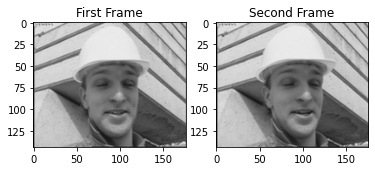

In [2]:
first_frame = plt.imread('first_frame.png')
second_frame = plt.imread('second_frame.png')
plt.rcParams["figure.figsize"] = (10,5)
first_frame = (first_frame*255).astype('uint8')
second_frame = (second_frame*255).astype('uint8')

plt.subplot(1,2,1)
imgplot = plt.imshow(first_frame,cmap = 'gray')
plt.title('First Frame')
plt.subplot(1,2,2)
imgplot = plt.imshow(second_frame,cmap = 'gray')
plt.title('Second Frame')
plt.show()

In [3]:
def block(img,x,y,size):
    return img[x:x+size,y:y+size]

### Function to estimate Motion Vectors using 3 step search approach

In [4]:
def motion_vector(first_frame,second_frame,block_size):
    first_frame = first_frame.astype('float32')
    second_frame = second_frame.astype('float32')
    M,N = first_frame.shape
    mv = np.zeros((M//block_size,N//block_size,2))
    for i in range(0,M,block_size):
        for j in range(0,N,block_size):
            
            block1 = block(second_frame,i,j,block_size)
            
            ## Compare with boxes at +-4 pixels in x and y direction
            min_diff = 1e6
            min_x = 0
            min_y = 0
            

            positions = [[-4,-4],[-4,0],[-4,4],[0,-4],[0,0],[0,4],[4,-4],[4,0],[4,4]]
            ## 3 step search
            for pos in positions:
                ## Check if the block is within the image
                if i+pos[0] <0 or i+pos[0]+block_size >= M or j+pos[1] <0 or j+pos[1]+block_size >= N:
                    continue
                block2 = block(first_frame,i+pos[0],j+pos[1],block_size)
                diff = np.mean(np.abs(block1-block2))
                if diff < min_diff:
                    min_diff = diff
                    min_x = pos[0]
                    min_y = pos[1]
     
            min_diff = 1e6
            search_x = i+min_x
            search_y = j+min_y
            positions  = [[i//2,j//2] for i,j in positions]

            ## Search all +- 2 neighbours
            for pos in positions:
                ## Check if the block is within the image
                if search_x+pos[0] <0 or search_x+pos[0]+block_size >=M or search_y+pos[1] <0 or search_y+pos[1]+block_size >= N:
                    continue
                block2 = block(second_frame,search_x+pos[0],search_y+pos[1],block_size)
                diff = np.mean(np.abs(block1-block2))
                if diff < min_diff:
                    min_diff = diff
                    min_x = pos[0]
                    min_y = pos[1]
              
            
            search_x = search_x+min_x
            search_y = search_y+min_y
            positions  = [[i//2,j//2] for i,j in positions]
            min_diff = 1e6
            ## Search all +- 1 neighbours
            for pos in positions:
                ## Check if the block is within the image
                if search_x+pos[0] <0 or search_x+pos[0]+block_size >= M or search_y+pos[1] <0 or search_y+pos[1]+block_size >= N:
                    continue
                block2 = block(first_frame,search_x+pos[0],search_y+pos[1],block_size)
                diff = np.mean(np.abs(block1-block2))
                if diff < min_diff:
                    min_diff = diff
                    min_x = pos[0]
                    min_y = pos[1]
            
            search_x = search_x+min_x
            search_y = search_y+min_y
            ## Calculate the motion vector
            mv[i//block_size,j//block_size,0] = i-search_x
            mv[i//block_size,j//block_size,1] = j-search_y
    
    return mv

### Function to draw motion vectors on the image

In [5]:
def draw_mv(img,mv,block_size = 16):
    scale_factor = 0.75
    M,N = img.shape
    fig,ax = plt.subplots()
    ax.imshow(img,cmap='gray')
    for i in range(mv.shape[0]):
        for j in range(mv.shape[1]):
            if mv[i,j,0] == 0 and mv[i,j,1] == 0:
                continue
            plt.arrow(block_size//2 +j*block_size,block_size//2 +i*block_size,scale_factor*mv[i,j,1],scale_factor*mv[i,j,0],head_width = 2, head_length = 3, color = 'g') 
    plt.title('First Frame with Motion Vectors')
    plt.axis('off')
    plt.show()

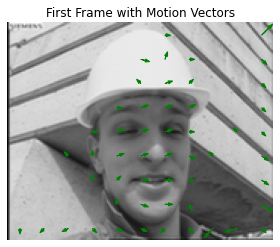

In [6]:
mv = motion_vector(first_frame,second_frame,16)
draw_mv(first_frame,mv)

#### The Blocks with no motion have not been represented with any arrows

### Function to predict the next frame using motion vectors and current frame

In [7]:
def predict_next_frame(first_frame,mv,block_size):
    next_frame = first_frame.copy().astype(np.float32)
    for i in range(mv.shape[0]):
        for j in range(mv.shape[1]):
            new_pos = [ int( i*block_size+mv[i,j,0]),int( j*block_size+mv[i,j,1])]
            
            ## Check if new pos is out of bounds
            if new_pos[0] < 0 or new_pos[0]+block_size >= first_frame.shape[0] or new_pos[1] < 0 or new_pos[1]+block_size >= first_frame.shape[1]:
                continue
            
            # print(block(first_frame,i*block_size,j*block_size,block_size).shape)
            next_frame[new_pos[0]:new_pos[0] + block_size ,new_pos[1]:new_pos[1]+block_size ] = block(first_frame,i*block_size,j*block_size,block_size)
    return next_frame

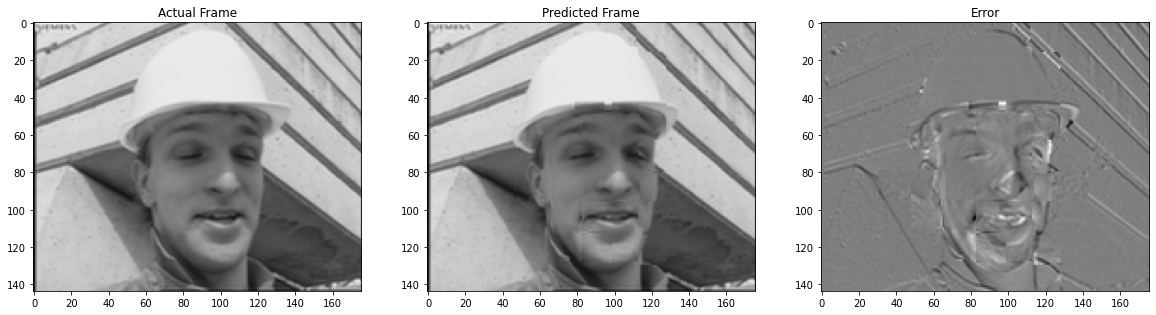

In [8]:
next_frame = predict_next_frame(first_frame,mv,16)
error = (next_frame - second_frame)

plt.figure(figsize=(20,20))
plt.subplot(1,3,1)
plt.title('Actual Frame')
plt.imshow(second_frame,cmap='gray')

plt.subplot(1,3,2)
plt.title("Predicted Frame")
plt.imshow(next_frame,cmap='gray')

plt.subplot(1,3,3)
plt.title("Error")
plt.imshow(error,cmap='gray')

plt.show()

### MAD Calculation

In [9]:
MAD = np.mean(np.abs(error))
print(f"MAD = {MAD}")

MAD = 3.51621675491333
